In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import os
import math
import soundfile as sf
import tensorflow as tf
from tensorflow import keras

In [2]:
print(tf.version.VERSION)

2.4.0


In [3]:
import tensorflow as tf
from tensorflow import keras

with tf.compat.v1.Session() as sess:
    devices = sess.list_devices()
    
devices

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)

import tensorflow.keras.backend as tf_backend
tf.compat.v1.keras.backend.set_session(sess)

In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Path to segmented files

In [4]:
path3 = '../GTzan_3f_Win_110250_75_safaa'

frame_size = 110250
nb_classes = 10

## List files

In [5]:
file_list = []
i = 0
for path, subdirs, files in os.walk(path3):
    for file in files:
        file_list.append(os.path.join(path,file))
        i += 1

print("Number of files processed : " + str(i))

Number of files processed : 20990


In [6]:
Train = "fold1"
Valid = "fold2"
Test  = "fold3"

In [7]:
train_list = []
valid_list = []
test_list  = []

train_path = []
valid_path = []
test_path  = []

train_label_list = []
valid_label_list = []
test_label_list  = []

train_seg_list = []
valid_seg_list = []
test_seg_list  = []

choices = {'blues': 0,
           'classical': 1,
           'country': 2,
           'disco': 3,
           'hiphop': 4,
           'jazz': 5,
           'metal': 6,
           'pop': 7,
           'reggae': 8,
           'rock': 9}

i = 0
for path, subdirs, files in os.walk(path3):
    for file in files:
        fold_num = path.split('/')[2]
        label_id = choices.get(path.split('/')[3], 99)
        track_id = file[0:].split('.')[0]
        track_id_t = int(file[0:].split('.')[0].split('_')[0])
        seg_id = int(file.split('.')[0].split('_')[1])
        full_path_id = path+'/'+file
        if fold_num == Train:
            train_list.append( track_id )
            train_path.append( full_path_id )
            train_label_list.append( label_id )
            train_seg_list.append( seg_id )
        if fold_num == Valid:
            valid_list.append( track_id )
            valid_path.append( full_path_id )
            valid_label_list.append( label_id )
            valid_seg_list.append( seg_id )
        if fold_num == Test:
            test_list.append( track_id )
            test_path.append( full_path_id )
            test_label_list.append( label_id )
            test_seg_list.append( seg_id )
        i += 1

print("Number of files processed: " + str(i))
print("Number of Train files: " + str(len(train_list)))
print("Number of Valid files: " + str(len(valid_list)))
print("Number of Test files: " + str(len(test_list)))

Number of files processed: 20990
Number of Train files: 7011
Number of Valid files: 6989
Number of Test files: 6990


In [8]:
full_path_id

'../GTzan_3f_Win_110250_75_safaa/fold1/rock/974_11.wav'

In [9]:
partition = {}
partition['train'] = train_path
partition['valid'] = valid_path
partition['test']  = test_path

In [10]:
labels = {}
for i in range(len(train_path)):
    labels[train_path[i]] = train_label_list[i]

for i in range(len(valid_path)):
    labels[valid_path[i]] = valid_label_list[i]
    
for i in range(len(test_path)):
    labels[test_path[i]] = test_label_list[i]

In [11]:
len(partition['train']), len(partition['valid']), len(partition['test'])

(7011, 6989, 6990)

In [12]:
train_path[0]

'../GTzan_3f_Win_110250_75_safaa/fold1/metal/689_20.wav'

In [13]:
class DataGenerator( keras.utils.Sequence ):
    'Generates data for Keras'

    def __init__(self, list_IDs, labels, batch_size = 100, dim = (110250, 1), n_classes = 10, shuffle = True, data_set = 0):
        'Initialization'
        self.dim        = dim
        self.batch_size = batch_size
        self.labels     = labels
        self.list_IDs   = list_IDs
        self.n_classes  = n_classes
        self.shuffle    = shuffle
        self.data_set   = data_set
        self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int( np.floor( len( self.list_IDs) / self.batch_size ) )
        
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[ index * self.batch_size:(index + 1) * self.batch_size ]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.list_IDs) )
        if self.shuffle == True:
            np.random.shuffle( self.indexes )
        
    def __data_generation( self, list_IDs_temp ):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty( ( self.batch_size, *self.dim ) )
        y = np.empty( ( self.batch_size ), dtype = int )
        
        # Generate data
        for i, ID in enumerate( list_IDs_temp ):
                        
            spcharray = np.asarray( sf.read(ID)[0] )       
            X[i,] = np.expand_dims( spcharray, axis = 1 )
            
            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical( y, num_classes = self.n_classes )       

In [14]:
from tensorflow.keras.models import Sequential

# Parameters
params = {'dim': (110250, 1),
          'batch_size': 100,
          'n_classes': 10,
          'shuffle': True,
         'data_set': 0}

# Generators
training_generator   = DataGenerator(partition['train'], labels, **params)

params2 = {'dim': (110250, 1),
          'batch_size': 100,
          'n_classes': 10,
          'shuffle': True,
         'data_set': 1}

validation_generator = DataGenerator(partition['valid'], labels, **params2)

In [15]:
frame_size = 110250
nb_classes = 10

In [16]:
def model_5layer():
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.layers import AveragePooling1D, Conv1D, MaxPool1D, Flatten
    from tensorflow.keras.models import Model
    from tensorflow.keras import initializers
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.layers import LeakyReLU    
    
    from tensorflow.keras import optimizers
    from tensorflow.keras.layers import BatchNormalization
    from tensorflow.keras.layers import Dropout
    
    import tensorflow.keras.initializers as init
    from tensorflow.keras.regularizers import l2
    
    inp =  Input( shape = (frame_size,1) )
    #----------------------
    conv1 = Conv1D(filters = 64, kernel_size = 7, activation = 'relu', padding = "valid", kernel_initializer = 'he_uniform')(inp)
    norm1 = BatchNormalization()(conv1)
    pool1 = MaxPool1D(pool_size = 3, strides = 3)(norm1)
    #----------------------
    conv2 = Conv1D(filters = 64, kernel_size = 7, strides = 1, activation = 'relu', padding = 'same',  kernel_initializer = 'he_uniform')(pool1)
    norm2 = BatchNormalization()(conv2)
    pool2 = MaxPool1D(pool_size = 3, strides = 3)(norm2)
    #----------------------
    conv3 = Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same',  kernel_initializer = 'he_uniform' )(pool2)
    norm3 = BatchNormalization()(conv3)
    pool3 = MaxPool1D(pool_size = 3, strides = 3)(norm3)
    #----------------------
    conv4 = Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same',  kernel_initializer = 'he_uniform' )(pool3)
    norm4 = BatchNormalization()(conv4)
    pool4 = MaxPool1D(pool_size = 3, strides = 3)(norm4)
    #----------------------
    conv5 = Conv1D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', padding = 'same',  kernel_initializer = 'he_uniform' )(pool4)
    norm5 = BatchNormalization()(conv5)
    pool5 = MaxPool1D(pool_size = 3, strides = 3)(norm5)
   
    
    drop = Dropout(0.5)(pool5)

    flat = Flatten()(drop)
    
    dense = Dense(nb_classes, activation='sigmoid')(flat)
    model  = Model(inp, dense)

    model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=1e-08, decay=0.0)
              ,metrics=['accuracy'])
    
    model.summary()
    
    return model

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot    import PlotLossesKeras
from tensorflow.keras           import optimizers

# Generating the model 
model = model_5layer()

# Checkpoints 
str1     = "XXXXYYYYXXXXX"
str2     = ".best.hdf5" 
file_path = str1 + str2 
print( file_path )

checkpointer = ModelCheckpoint(monitor='val_accuracy', mode='max', filepath = file_path,
                               save_best_only=True, verbose=1 ) 
earlystopper = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=0,
                             mode='max', baseline=None, restore_best_weights=True)

callbacks_list = [checkpointer, earlystopper, PlotLossesKeras()]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 110250, 1)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 110244, 64)        512       
_________________________________________________________________
batch_normalization (BatchNo (None, 110244, 64)        256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 36748, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 36748, 64)         28736     
_________________________________________________________________
batch_normalization_1 (Batch (None, 36748, 64)         256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12249, 64)         0     

In [18]:
history = model.fit_generator(generator = training_generator,
                    epochs   = 30,
                    validation_data = validation_generator,
                    callbacks = [PlotLossesKeras(), checkpointer, earlystopper ]
                    )

/home/aq53590/.local/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
24/70 [=========>....................] - ETA: 11:03 - loss: 4.9070 - accuracy: 0.2361

KeyboardInterrupt: 

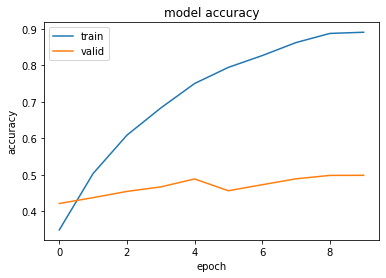

In [22]:
import matplotlib.pyplot as plt

#summarizing the history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("Accuracy5LayerCNN.png")
plt.show()

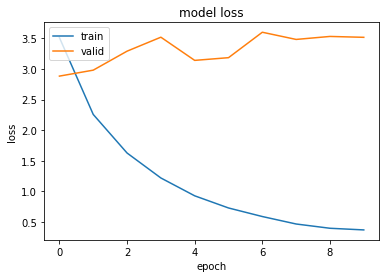

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig("Loss5LayerCNN.png")
plt.show()